In [13]:
import itertools
import numpy as np
from dataclasses import dataclass
from typing import Tuple, List, Optional

from scipy.optimize import linprog, minimize, minimize_scalar
from scipy.sparse import coo_matrix, csr_matrix


# --------------------------
# Utilities
# --------------------------

def all_bitstrings(n: int) -> np.ndarray:
    return np.array(list(itertools.product([0, 1], repeat=n)), dtype=int)


def all_branches(n: int, h: int) -> List[Tuple[Tuple[int, ...], Tuple[int, ...]]]:
    k = n - h
    branches = []
    for A in itertools.combinations(range(n), k):
        for aA in itertools.product([0, 1], repeat=k):
            branches.append((tuple(A), tuple(aA)))
    return branches


def sigmoid(z):
    z = np.clip(z, -40, 40)
    return 1.0 / (1.0 + np.exp(-z))


def linprog_any(c, A_ub, b_ub, A_eq, b_eq, bounds):
    methods = ("highs", "highs-ds", "highs-ipm", "interior-point", "revised simplex", "simplex")
    last_err = None
    for method in methods:
        try:
            return linprog(
                c=c, A_ub=A_ub, b_ub=b_ub,
                A_eq=A_eq, b_eq=b_eq,
                bounds=bounds,
                method=method
            )
        except ValueError as e:
            last_err = e
            continue
    if last_err is not None:
        raise last_err
    raise RuntimeError("linprog failed unexpectedly.")


def cache_key_from_s(s: np.ndarray, *, tol: float = 1e-4) -> tuple:
    s = np.clip(np.asarray(s, dtype=float), 0.0, 1.0)
    q = np.round(s / tol).astype(np.int64)
    diffs = np.diff(q)
    return (int(q[0]), *map(int, diffs))


# --------------------------
# Inner LP solver
# --------------------------

@dataclass
class LPValue:
    ok: bool
    t: float
    f: Optional[np.ndarray]
    msg: str


class FullProgramLPSolver:
    """
    Precomputes A_ub CSR structure once; per solve only fills data.
    """

    def __init__(
        self,
        n: int,
        h: int,
        C: float,
        cache_tol: float = 1e-4,
        cache_max: int = 200_000,
        profile: bool = True,
    ):
        self.n = int(n)
        self.h = int(h)
        self.C = float(C)

        self.bits = all_bitstrings(self.n)  # (m,n)
        self.m = self.bits.shape[0]
        self.all_zero = (self.bits.sum(axis=1) == 0).astype(float)  # (m,)

        self.branches = all_branches(self.n, self.h)
        self.num_branches = len(self.branches)

        # Variable layout: x = vec(f) then t at the end
        self.N = self.n * self.m + 1
        self.t_idx = self.n * self.m
        self.bounds = [(0.0, None)] * (self.n * self.m) + [(0.0, None)]
        self.c = np.zeros(self.N, dtype=float)
        self.c[self.t_idx] = 1.0

        # Precompute eq index sets
        self.eq_idx1 = [np.where(self.bits[:, i] == 1)[0] for i in range(self.n)]
        self.eq_idx0 = [np.where(self.bits[:, i] == 0)[0] for i in range(self.n)]
        self.eq_cols1 = [i * self.m + self.eq_idx1[i] for i in range(self.n)]
        self.eq_cols0 = [i * self.m + self.eq_idx0[i] for i in range(self.n)]

        # Branch precompute
        all_idx = np.arange(self.n)
        self.branch_match_idx: List[np.ndarray] = []
        self.branch_cols_per_i: List[List[np.ndarray]] = []
        self.branch_comp_cols: List[np.ndarray] = []
        self.branch_has_zero = np.zeros(self.num_branches, dtype=bool)

        for b, (A, aA) in enumerate(self.branches):
            mask = np.ones(self.m, dtype=bool)
            for pos, j in enumerate(A):
                mask &= (self.bits[:, j] == aA[pos])
            idx = np.where(mask)[0]
            self.branch_match_idx.append(idx)
            self.branch_cols_per_i.append([i * self.m + idx for i in range(self.n)])

            Aset = set(A)
            comp = np.array([j for j in all_idx if j not in Aset], dtype=int)  # size h
            self.branch_comp_cols.append(comp)

            self.branch_has_zero[b] = (idx.size > 0 and idx[0] == 0) or (0 in set(idx.tolist()))

        # ----------------------
        # Precompute A_ub COO pattern and CSR template/permutation
        # ----------------------
        self.num_ub = 1 + self.num_branches

        total_nnz = self.n * self.m
        for idx in self.branch_match_idx:
            total_nnz += self.n * idx.size + 1

        self._ub_rows = np.empty(total_nnz, dtype=int)
        self._ub_cols = np.empty(total_nnz, dtype=int)

        self._ir_slices: List[slice] = []
        self._branch_slices: List[List[slice]] = []
        self._t_pos = np.empty(self.num_branches, dtype=int)

        off = 0
        # IR row (row 0): n blocks each of length m
        for i in range(self.n):
            cols = i * self.m + np.arange(self.m, dtype=int)
            self._ub_rows[off:off + self.m] = 0
            self._ub_cols[off:off + self.m] = cols
            self._ir_slices.append(slice(off, off + self.m))
            off += self.m

        # Branch rows
        for b in range(self.num_branches):
            row = 1 + b
            idx = self.branch_match_idx[b]
            b_slices = []
            for i in range(self.n):
                cols = self.branch_cols_per_i[b][i]
                L = cols.size
                self._ub_rows[off:off + L] = row
                self._ub_cols[off:off + L] = cols
                b_slices.append(slice(off, off + L))
                off += L

            # -t entry
            self._ub_rows[off] = row
            self._ub_cols[off] = self.t_idx
            self._t_pos[b] = off
            off += 1
            self._branch_slices.append(b_slices)

        assert off == total_nnz

        # Build CSR template once; use ids to get COO->CSR permutation
        ids = np.arange(total_nnz, dtype=float)
        csr_template = coo_matrix((ids, (self._ub_rows, self._ub_cols)),
                                  shape=(self.num_ub, self.N)).tocsr()

        self._ub_perm = csr_template.data.astype(np.int64)  # CSR position -> COO id
        self._ub_indices = csr_template.indices.copy()
        self._ub_indptr = csr_template.indptr.copy()

        # Cache
        self.cache_tol = float(cache_tol)
        self._cache: dict[tuple, LPValue] = {}
        self._cache_max = int(cache_max)

        # Profiling
        self.profile = bool(profile)
        self._prof = {
            "calls": 0,
            "cache_hits": 0,
            "build_eq_s": 0.0,
            "build_ub_s": 0.0,
            "linprog_s": 0.0,
            "total_s": 0.0,
        }

    def solve_lp(self, s: np.ndarray, return_f: bool = False) -> LPValue:
        import time
        t0 = time.perf_counter()
        if self.profile:
            self._prof["calls"] += 1

        s = np.clip(np.asarray(s, dtype=float), 0.0, 1.0)

        key = cache_key_from_s(s, tol=self.cache_tol)
        cached = self._cache.get(key)
        if cached is not None and ((not return_f) or (cached.f is not None)):
            if self.profile:
                self._prof["cache_hits"] += 1
                self._prof["total_s"] += time.perf_counter() - t0
            return cached

        n, m, C = self.n, self.m, self.C
        N = self.N

        # term + pi
        s_safe = np.clip(s, 1e-12, 1 - 1e-12)
        term = np.where(self.bits == 1, s_safe[None, :], (1.0 - s_safe)[None, :])  # (m,n)
        pi = term.prod(axis=1)  # (m,)

        # ----------------------
        # Build A_eq (small)
        # ----------------------
        t_eq0 = time.perf_counter()

        eq_rows = []
        eq_cols = []
        eq_data = []

        for i in range(n):
            w_i = pi / term[:, i]
            idx1 = self.eq_idx1[i]
            idx0 = self.eq_idx0[i]
            cols1 = self.eq_cols1[i]
            cols0 = self.eq_cols0[i]

            eq_rows.append(np.full(cols1.shape[0], i, dtype=int))
            eq_cols.append(cols1.astype(int))
            eq_data.append(w_i[idx1])

            eq_rows.append(np.full(cols0.shape[0], i, dtype=int))
            eq_cols.append(cols0.astype(int))
            eq_data.append(-w_i[idx0])

        A_eq = coo_matrix(
            (np.concatenate(eq_data), (np.concatenate(eq_rows), np.concatenate(eq_cols))),
            shape=(n, N),
        ).tocsr()
        b_eq = np.ones(n, dtype=float)

        if self.profile:
            self._prof["build_eq_s"] += time.perf_counter() - t_eq0

        # ----------------------
        # Build A_ub (fill data only)
        # ----------------------
        t_ub0 = time.perf_counter()

        data_coo = np.empty_like(self._ub_rows, dtype=float)
        b_ub = np.zeros(self.num_ub, dtype=float)

        # IR row blocks: -pi
        for sl in self._ir_slices:
            data_coo[sl] = -pi
        b_ub[0] = -float(s.sum())

        # Branch rows
        for b in range(self.num_branches):
            comp = self.branch_comp_cols[b]  # size h
            if comp.size == 0:
                w = np.ones(m, dtype=float)
            else:
                w = term[:, comp].prod(axis=1)  # (m,)

            idx = self.branch_match_idx[b]
            w_idx = w[idx]

            for i in range(n):
                data_coo[self._branch_slices[b][i]] = w_idx

            data_coo[self._t_pos[b]] = -1.0

            # RHS constant depends only on all-zero assignment (bitstring 000..0 is index 0)
            b_ub[1 + b] = -C * float(w[0]) if self.branch_has_zero[b] else 0.0

        data_csr = data_coo[self._ub_perm]
        A_ub = csr_matrix((data_csr, self._ub_indices, self._ub_indptr), shape=(self.num_ub, self.N))

        if self.profile:
            self._prof["build_ub_s"] += time.perf_counter() - t_ub0

        # ----------------------
        # Solve LP
        # ----------------------
        t_lp0 = time.perf_counter()
        res = linprog_any(self.c, A_ub, b_ub, A_eq, b_eq, self.bounds)
        if self.profile:
            self._prof["linprog_s"] += time.perf_counter() - t_lp0

        if not res.success:
            val = LPValue(ok=False, t=float("inf"), f=None, msg=str(res.message))
            if len(self._cache) < self._cache_max:
                self._cache[key] = val
            if self.profile:
                self._prof["total_s"] += time.perf_counter() - t0
            return val

        t_val = float(res.fun)
        if not return_f:
            val = LPValue(ok=True, t=t_val, f=None, msg="OK")
            if len(self._cache) < self._cache_max:
                self._cache[key] = val
            if self.profile:
                self._prof["total_s"] += time.perf_counter() - t0
            return val

        x = res.x
        f = x[: n * m].reshape((n, m))
        val = LPValue(ok=True, t=t_val, f=f, msg="OK")
        if len(self._cache) < self._cache_max:
            self._cache[key] = val
        if self.profile:
            self._prof["total_s"] += time.perf_counter() - t0
        return val

    def print_profile(self, label: str = ""):
        p = self._prof
        calls = p["calls"]
        hits = p["cache_hits"]
        misses = calls - hits
        head = f"=== solve_lp profile {label} ===".strip()
        print("\n" + head)
        print(f"calls:      {calls}")
        print(f"cache_hits: {hits} ({hits / max(1, calls):.1%})")
        print(f"misses:     {misses} ({misses / max(1, calls):.1%})")
        print(f"build_eq:   {p['build_eq_s']:.3f}s")
        print(f"build_ub:   {p['build_ub_s']:.3f}s")
        print(f"linprog:    {p['linprog_s']:.3f}s")
        print(f"total:      {p['total_s']:.3f}s")


# --------------------------
# Outer optimization (NO faces) + symmetric 1D safeguard
# --------------------------

@dataclass
class SearchResult:
    ok: bool
    t: float
    s: np.ndarray
    f: Optional[np.ndarray]   # (n, 2^n) if ok else None
    msg: str


def s_from_z_monotone(z: np.ndarray) -> np.ndarray:
    """
    Smooth monotone map R^n -> {1 >= s1 >= ... >= sn >= 0} without sorting.
    s1 = sigmoid(z1)
    si = s_{i-1} * sigmoid(zi)
    """
    z = np.asarray(z, dtype=float)
    s = np.empty_like(z)
    s[0] = sigmoid(z[0])
    for i in range(1, z.size):
        s[i] = s[i - 1] * sigmoid(z[i])
    return s


def z_from_s_monotone(s: np.ndarray) -> np.ndarray:
    """
    Inverse-ish map for initialization:
      z1 = logit(s1)
      zi = logit(si / s_{i-1}) for i>=2
    """
    s = np.clip(np.asarray(s, dtype=float), 1e-8, 1 - 1e-8)

    def logit(u):
        u = np.clip(u, 1e-8, 1 - 1e-8)
        return np.log(u / (1 - u))

    z = np.empty_like(s)
    z[0] = logit(s[0])
    for i in range(1, s.size):
        ratio = s[i] / max(s[i - 1], 1e-12)
        z[i] = logit(np.clip(ratio, 1e-8, 1 - 1e-8))
    return z


def blocky_seeds(n: int, rng: np.random.Generator) -> List[np.ndarray]:
    """
    Monotone 'face-like' s vectors as STARTS (not constraints).
    """
    seeds: list[np.ndarray] = []

    # 1) Spike + flat tail: [1, u, ..., u]
    for u in np.linspace(0.05, 0.8, 20):
        s = np.full(n, float(u), dtype=float)
        s[0] = 1.0
        seeds.append(s)

    # 2) Slightly relaxed spike
    for u in np.linspace(0.05, 0.8, 10):
        for top in (0.98, 0.995, 0.999):
            s = np.full(n, float(u), dtype=float)
            s[0] = float(top)
            seeds.append(s)

    # 3) Two-block step
    for k in range(1, n):
        for _ in range(8):
            a = rng.uniform(0.6, 1.0)
            b = rng.uniform(0.0, min(a, 0.6))
            s = np.empty(n)
            s[:k] = a
            s[k:] = b
            seeds.append(s)

    # 4) Three-block step
    for _ in range(30):
        k1 = int(rng.integers(1, n - 1))
        k2 = int(rng.integers(1, n - k1))
        a = rng.uniform(0.7, 1.0)
        b = rng.uniform(0.2, min(a, 0.8))
        c = rng.uniform(0.0, min(b, 0.5))
        s = np.empty(n)
        s[:k1] = a
        s[k1:k1 + k2] = b
        s[k1 + k2:] = c
        seeds.append(s)

    # 5) Stick-breaking monotone
    for _ in range(50):
        s = np.empty(n)
        s[0] = rng.uniform(0.5, 1.0)
        for i in range(1, n):
            s[i] = s[i - 1] * rng.uniform(0.0, 1.0)
        seeds.append(s)

    return seeds


def best_fully_symmetric(solver: FullProgramLPSolver):
    """
    Minimize t(u) over u in (0,1) where s = u * 1.
    Returns (t_best, s_best, f_best).
    """
    n = solver.n

    def obj_u(u):
        u = float(np.clip(u, 1e-10, 1 - 1e-10))
        s = np.full(n, u, dtype=float)
        val = solver.solve_lp(s, return_f=False)
        return val.t if val.ok else 1e6

    res = minimize_scalar(
        obj_u,
        bounds=(1e-6, 1 - 1e-6),
        method="bounded",
        options={"xatol": 1e-6, "maxiter": 200},
    )

    u_star = float(np.clip(res.x, 1e-10, 1 - 1e-10))
    s_star = np.full(n, u_star, dtype=float)
    lp_star = solver.solve_lp(s_star, return_f=True)

    if not lp_star.ok:
        return float("inf"), s_star, None
    return float(lp_star.t), s_star, lp_star.f


def minimize_over_s_unconstrained(
    solver: FullProgramLPSolver,
    n_random: int = 300,
    n_blocky_starts: int = 80,
    n_random_starts: int = 12,
    seed: int = 0,
    local_method: str = "Powell",
    maxiter: int = 600,
    add_best_scan_start: bool = True,
) -> SearchResult:
    n = solver.n
    rng = np.random.default_rng(seed)

    # --- phase 0: symmetric 1D solve (guarantees you don't miss the symmetric optimum) ---
    sym_t, sym_s, sym_f = best_fully_symmetric(solver)

    # --- phase 1: random scan in z-space -> monotone s ---
    best_t = float("inf")
    best_s = None

    for _ in range(n_random):
        z = rng.normal(size=n)
        s = s_from_z_monotone(z)
        val = solver.solve_lp(s, return_f=False)
        if val.ok and val.t < best_t:
            best_t = val.t
            best_s = s.copy()

    if best_s is None:
        best_s = np.full(n, 0.5, dtype=float)
        best_t = solver.solve_lp(best_s, return_f=False).t

    # Compare against symmetric candidate early
    if sym_t < best_t:
        best_t = sym_t
        best_s = sym_s.copy()

    # --- objective in z-space ---
    def obj(z):
        s = s_from_z_monotone(z)
        val = solver.solve_lp(s, return_f=False)
        return val.t if val.ok else 1e6

    # --- starts: best scan, symmetric optimum, blocky seeds, random ---
    starts: list[np.ndarray] = []
    if add_best_scan_start:
        starts.append(z_from_s_monotone(best_s))
    starts.append(z_from_s_monotone(sym_s))  # crucial

    bseeds = blocky_seeds(n, rng)
    rng.shuffle(bseeds)
    for s0 in bseeds[: max(0, n_blocky_starts)]:
        starts.append(z_from_s_monotone(s0))

    for _ in range(max(0, n_random_starts)):
        starts.append(rng.normal(size=n))

    # --- local searches ---
    best_z = None
    best_local = best_t

    for z0 in starts:
        res = minimize(obj, z0, method=local_method, options={"maxiter": maxiter, "disp": False})
        fval = float(res.fun)
        if fval < best_local:
            best_local = fval
            best_z = np.array(res.x, copy=True)

    # Get f for the full-search candidate
    s_full = s_from_z_monotone(best_z) if best_z is not None else best_s
    lp_full = solver.solve_lp(s_full, return_f=True)

    # Return best of (symmetric 1D) vs (full search)
    if sym_t < lp_full.t:
        if sym_f is None:
            lp_sym = solver.solve_lp(sym_s, return_f=True)
            return SearchResult(lp_sym.ok, lp_sym.t, sym_s, lp_sym.f, "OK (symmetric 1D winner)")
        return SearchResult(True, sym_t, sym_s, sym_f, "OK (symmetric 1D winner)")

    return SearchResult(lp_full.ok, lp_full.t, s_full, lp_full.f, lp_full.msg)

In [27]:
n = 4
C = 7.0

outer_kwargs = dict(
    n_random=250,
    n_blocky_starts=120,
    n_random_starts=10,
    seed=1,
    local_method="Powell",
    maxiter=500,
)

for h in [1]:
    print(f"\n{'='*60}")
    print(f"Solving n={n}, h={h}, C={C}")

    solver = FullProgramLPSolver(
        n=n,
        h=h,
        C=C,
        cache_tol=1e-4,
        cache_max=200_000,
        profile=True,
    )

    res = minimize_over_s_unconstrained(solver, **outer_kwargs)

    print(
        f"\nRESULT (NO faces) n={n}, h={h}, C={C}\n"
        f"  t={res.t: .6g}\n"
        f"  s={np.array2string(res.s, precision=6, floatmode='fixed')}\n"
        f"  ok={res.ok}, msg={res.msg}\n"
        f"  f shape={None if res.f is None else res.f.shape}"
    )

    if res.f is not None:
        # show a small slice
        print("  f[0, :8] =", np.array2string(res.f[0, :8], precision=6, floatmode='fixed'))

    solver.print_profile(label=f"(n={n}, h={h}, C={C})")


Solving n=4, h=1, C=7.0

RESULT (NO faces) n=4, h=1, C=7.0
  t= 2.63494
  s=[0.623613 0.623613 0.623613 0.623613]
  ok=True, msg=OK
  f shape=(4, 16)
  f[0, :8] = [0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000]

=== solve_lp profile (n=4, h=1, C=7.0) ===
calls:      23165
cache_hits: 16455 (71.0%)
misses:     6710 (29.0%)
build_eq:   1.124s
build_ub:   1.701s
linprog:    6.803s
total:      10.665s


In [28]:
def print_nonzero_payments(f, tol=1e-6):
    n, m = f.shape
    bits = list(itertools.product([0,1], repeat=n))
    for i in range(n):
        for j in range(m):
            if abs(f[i, j]) > tol:
                b = ''.join(map(str, bits[j]))
                print(f"p_{i+1}({b}) = {f[i,j]:.8f}")

In [29]:
print_nonzero_payments(res.f)

p_1(1000) = 0.00036414
p_1(1011) = 1.67520511
p_1(1101) = 1.67520511
p_1(1111) = 2.10114557
p_2(0100) = 0.00036414
p_2(0101) = 1.35621769
p_2(1100) = 4.22506043
p_2(1110) = 1.67520511
p_2(1111) = 1.07906114
p_3(0010) = 0.00036414
p_3(0110) = 4.22506043
p_3(0111) = 1.67520511
p_3(1010) = 4.22506043
p_3(1111) = 0.03398764
p_4(0001) = 0.00036414
p_4(0011) = 4.22506043
p_4(0101) = 2.86884274
p_4(1001) = 4.22506043


In [30]:
import numpy as np
import itertools

def all_bitstrings(n: int) -> np.ndarray:
    return np.array(list(itertools.product([0, 1], repeat=n)), dtype=int)

def build_k_symmetrized_rule_from_f(f_old: np.ndarray):
    """
    f_old: shape (n, 2^n), columns in itertools.product([0,1], repeat=n) order.
    Returns f_new with:
      - compute avg total payment among outcomes with k ones: avgT[k]
      - each deliverer in a k-outcome gets q_k = avgT[k]/k, non-deliverers get 0
    """
    n, m = f_old.shape
    assert m == 2**n
    bits = all_bitstrings(n)
    k = bits.sum(axis=1)  # (m,)

    T = f_old.sum(axis=0)  # total payment per outcome, shape (m,)

    avgT = {}
    q = {}
    for kk in range(1, n+1):
        mask = (k == kk)
        if np.any(mask):
            avgT[kk] = float(T[mask].mean())
            q[kk] = avgT[kk] / kk
        else:
            avgT[kk] = 0.0
            q[kk] = 0.0

    f_new = np.zeros_like(f_old, dtype=float)
    for j in range(m):
        kk = int(k[j])
        if kk == 0:
            continue
        deliverers = np.where(bits[j] == 1)[0]
        f_new[deliverers, j] = q[kk]

    return f_new, avgT, q

def equilibrium_equalities_residual(s: np.ndarray, f: np.ndarray):
    """
    Checks the 'A_eq @ x = 1' conditions your LP encodes, but for a fixed f.
    Returns residual vector r where r[i] = (lhs_i - 1).
    """
    s = np.asarray(s, dtype=float)
    n = s.size
    bits = all_bitstrings(n)              # (m,n)
    m = bits.shape[0]
    assert f.shape == (n, m)

    s_safe = np.clip(s, 1e-12, 1 - 1e-12)
    term = np.where(bits == 1, s_safe[None, :], (1.0 - s_safe)[None, :])  # (m,n)
    pi = term.prod(axis=1)  # (m,)

    r = np.zeros(n, dtype=float)
    for i in range(n):
        w_i = pi / term[:, i]  # (m,)
        idx1 = (bits[:, i] == 1)
        idx0 = (bits[:, i] == 0)

        lhs = float(np.sum(w_i[idx1] * f[i, idx1]) - np.sum(w_i[idx0] * f[i, idx0]))
        r[i] = lhs - 1.0
    return r

# -----------------------
# Example usage
# -----------------------
# Suppose you already have your LP-produced f in a numpy array named f_old.
# f_old shape must be (4,16).

# s_sym = np.array([0.623613, 0.623613, 0.623613, 0.623613])
# f_new, avgT, q = build_k_symmetrized_rule_from_f(f_old)
# res = equilibrium_equalities_residual(s_sym, f_new)
# print("avg total by k:", avgT)
# print("per-deliverer q_k:", q)
# print("IC equality residuals (should be ~0):", res)
# print("max abs residual:", np.max(np.abs(res)))


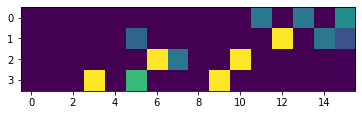

In [37]:
plt.imshow(res.f)

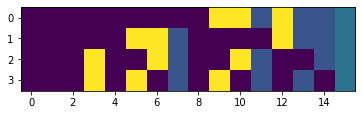

In [36]:
f_new, avgT, q = build_k_symmetrized_rule_from_f(res.f)
plt.imshow(f_new)

In [32]:
equilibrium_equalities_residual(np.array([0.623613, 0.623613, 0.623613, 0.623613]), res.f)

array([ 8.68790452e-07, -1.39216819e-07, -8.28577512e-07, -1.18442029e-06])